<a href="https://colab.research.google.com/github/arvindsuresh-math/Fall-2025-Team-Big-Data/blob/main/Naive_Random_Forests_for_NEW_AirBNB_NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
import fastbook
fastbook.setup_book()

In [50]:
from fastbook import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG


In [51]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
df_rs = pd.read_parquet('/content/gdrive/MyDrive/insideairbnb/nyc/nyc_dataset_oct_17.parquet')
display(df_rs.head(1))

,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
0,2595,2845,Skylit Midtown Castle Sanctuary,"Beautiful, spacious skylit studio in the heart of Midtown, Manhattan. 1 BED / FULL BATH / FULL KITCHEN / CENTRALLY LOCATED / HIGH SPEED WIFI",0,Midtown,40.75356,-73.98559,Entire rental unit,Entire home/apt,1,1.0,0,1,"Air conditioning, Baking sheet, Bathtub, Bed linens, Carbon monoxide alarm, Cleaning available during stay, Coffee maker, Cooking basics, Dedicated workspace, Dishes and silverware, Essentials, Ethernet connection, Extra pillows and blankets, Fire extinguisher, Free street parking, Hair dryer, Hangers, Heating, Hot water, Iron, Keypad, Kitchen, Long term stays allowed, Luggage dropoff allowed, Oven, Paid parking off premises, Refrigerator, Self check-in, Smoke alarm, Stove, TV, Wifi",30,4.68,4.73,4.63,4.77,4.8,4.81,4.4,240.0,11,240.0,5.484797,5.484797,47


In [53]:
dep_var = 'price'
cont_rs, cat_rs = cont_cat_split(df_rs, max_card=9000, dep_var=dep_var)

In [54]:
splits = RandomSplitter()(range_of(df_rs))
procs_rf = [Categorify, FillMissing]
to_rf = TabularPandas(df_rs, procs_rf, cat_rs, cont_rs, y_names=dep_var, splits=splits)

In [55]:
xs_rf, y_rf = to_rf.train.xs, to_rf.train.y
valid_xs_rf, valid_y_rf = to_rf.valid.xs, to_rf.valid.y

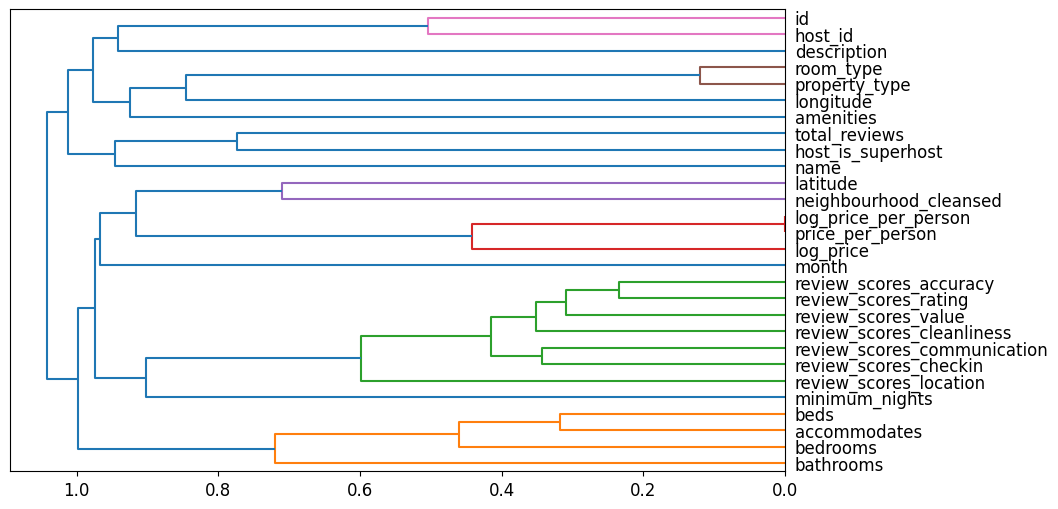

In [56]:
cluster_columns(xs_rf)

In [57]:
#
#
#
#
#

In [58]:
cont_loc = ['latitude', 'longitude']

In [59]:
cat_loc = ['neighbourhood_cleansed']

In [60]:
splits = RandomSplitter()(range_of(df_rs))

In [61]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [62]:
def rf(xs, y, n_estimators=40, max_samples=10000,max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs = -1, n_estimators=n_estimators, max_samples = max_samples, max_features = max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [63]:
def m_rmse(m, xs, y):
  return r_mse(m.predict(xs), y)

In [64]:
procs_rf = [Categorify, FillMissing]

In [65]:
to_loc = TabularPandas(df_rs, procs_rf, cat_loc, cont_loc, y_names=dep_var, splits=splits)

In [66]:
len(to_loc.train), len(to_loc.valid)

(119199, 29799)

In [67]:
xs_loc, y_loc = to_loc.train.xs, to_loc.train.y
valid_xs_loc, valid_y_loc = to_loc.valid.xs, to_loc.valid.y

In [68]:
m_loc = rf(xs_loc, y_loc)

In [69]:
m_rmse(m_loc, xs_loc, y_loc), m_rmse(m_loc, valid_xs_loc, valid_y_loc)

(136.962413, 138.459186)

In [70]:
preds_loc = np.stack([t.predict(valid_xs_loc) for t in m_loc.estimators_])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [71]:
r_mse(preds_loc.mean(0), valid_y_loc)

138.459186

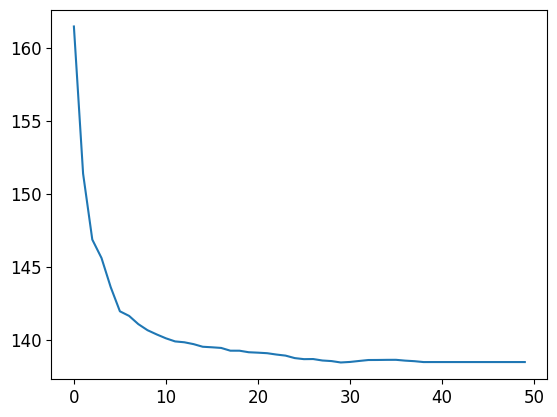

In [72]:
plt.plot([r_mse(preds_loc[:i+1].mean(0), valid_y_loc) for i in range(50)])

In [73]:
r_mse(m_loc.oob_prediction_, y_loc)

139.666068

In [74]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)

In [75]:
fi = rf_feat_importance(m_loc, xs_loc)
fi[:10]

,cols,imp
2,longitude,0.488002
1,latitude,0.413995
0,neighbourhood_cleansed,0.098003


In [76]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<Axes: ylabel='cols'>

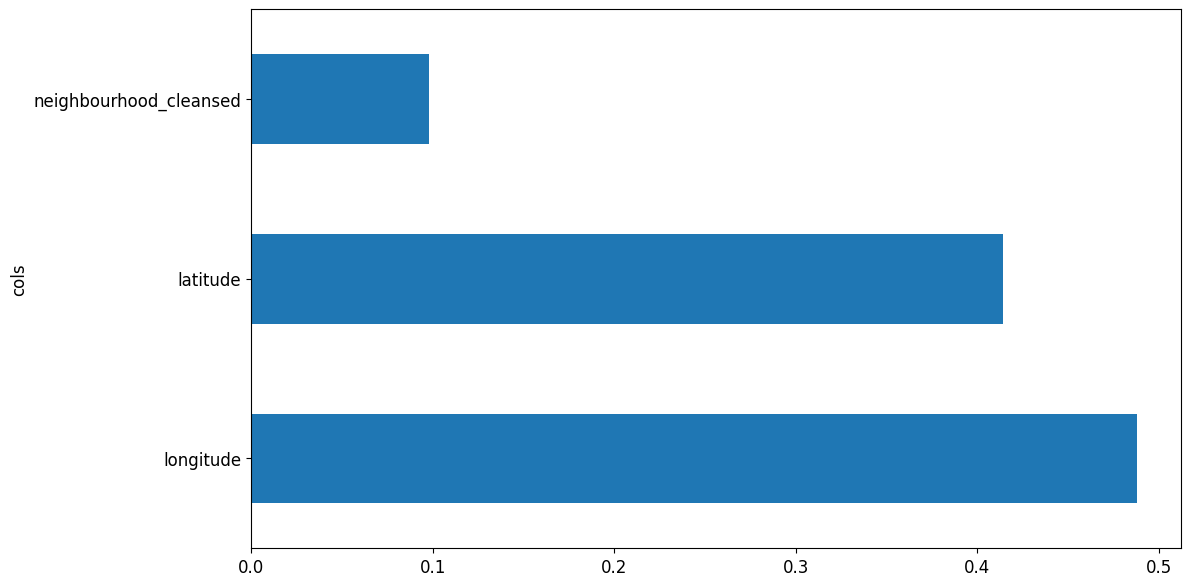

In [77]:
plot_fi(fi[:30])

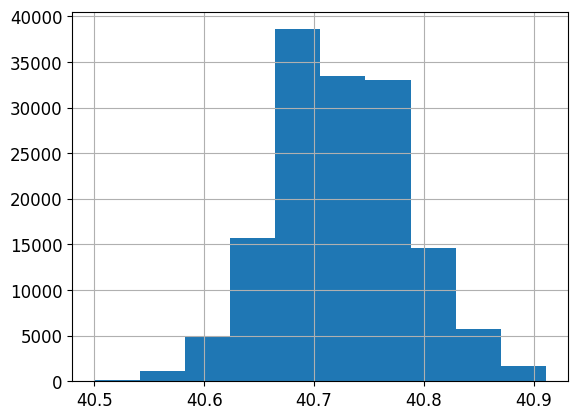

In [78]:
df_rs['latitude'].hist();

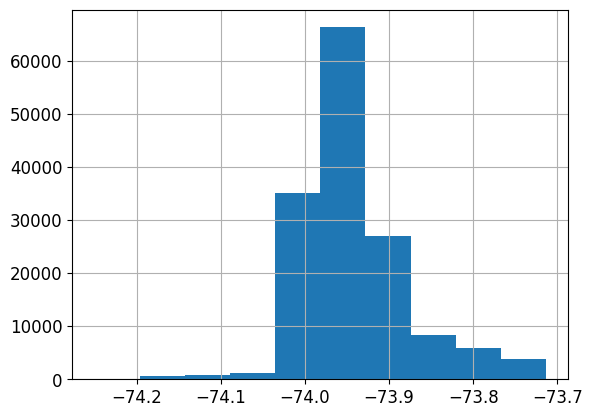

In [79]:
df_rs['longitude'].hist();

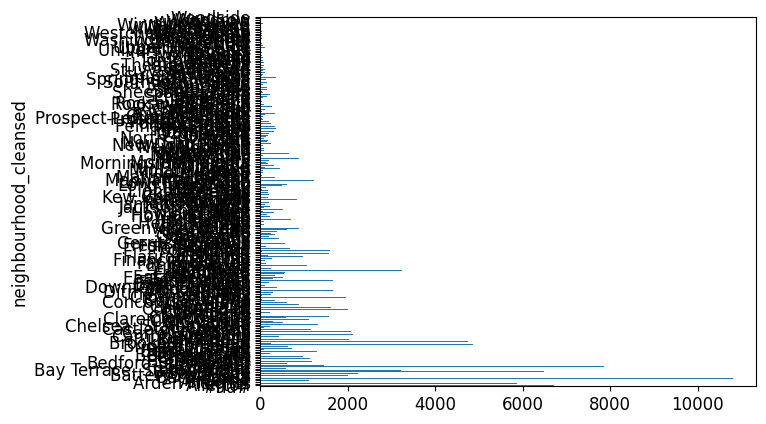

In [80]:
p = df_rs['neighbourhood_cleansed'].value_counts(sort=False).plot.barh()
c = to_loc.classes['neighbourhood_cleansed']
plt.yticks(range(len(c)), c);

In [81]:
#
#
#
#
#

In [82]:
cont_size = ['accommodates', 'bedrooms', 'bathrooms', 'beds']
cat_size = ['property_type', 'room_type']
to_size = TabularPandas(df_rs, procs_rf, cat_size, cont_size, y_names=dep_var, splits=splits)
xs_size, y_size = to_size.train.xs, to_size.train.y
valid_xs_size, valid_y_size = to_size.valid.xs, to_size.valid.y

m_size = rf(xs_size, y_size)
preds_size = np.stack([t.predict(valid_xs_size) for t in m_size.estimators_])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [83]:
r_mse(preds_size.mean(0), valid_y_size)

119.150157

In [84]:
r_mse(m_size.oob_prediction_, y_size)

120.196437

In [85]:
#
#
#
#
#

In [86]:
cont_rep = ['review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication','review_scores_location','review_scores_value']
cat_rep = ['host_is_superhost', 'total_reviews']
to_rep  = TabularPandas(df_rs, procs_rf, cat_rep , cont_rep , y_names=dep_var, splits=splits)
xs_rep , y_rep  = to_rep.train.xs, to_rep.train.y
valid_xs_rep , valid_y_rep  = to_rep.valid.xs, to_rep.valid.y

m_rep  = rf(xs_rep , y_rep )
preds_rep  = np.stack([t.predict(valid_xs_rep ) for t in m_rep.estimators_])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [87]:
r_mse(preds_rep.mean(0), valid_y_rep)

153.613667

In [88]:
r_mse(m_rep.oob_prediction_, y_rep)

155.596684

In [89]:
#
#
#
#
#

In [90]:
cont_mon = ['month']
cat_mon = []
to_mon  = TabularPandas(df_rs, procs_rf, cat_mon , cont_mon , y_names=dep_var, splits=splits)
xs_mon , y_mon  = to_mon.train.xs, to_mon.train.y
valid_xs_mon , valid_y_mon  = to_mon.valid.xs, to_mon.valid.y

m_mon  = rf(xs_mon , y_mon )
preds_mon  = np.stack([t.predict(valid_xs_mon ) for t in m_mon.estimators_])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [91]:
r_mse(preds_mon.mean(0), valid_y_mon)

173.338423

In [92]:
r_mse(m_mon.oob_prediction_, y_mon)

176.098397

In [93]:
#
#
#
#
#